#### 자전거 대여량 예측(GRU)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.model_selection import train_test_split

In [3]:
# 1. 데이터 불러오기
dataset_path = './dataset/'
train_data = pd.read_csv(dataset_path + 'train.csv')
test_data = pd.read_csv(dataset_path + 'test.csv')

In [4]:
# 2. 데이터 전처리
def preprocess_data(data):
    data['datetime'] = pd.to_datetime(data['datetime'])
    data['hour'] = data['datetime'].dt.hour
    data['day'] = data['datetime'].dt.day
    data['month'] = data['datetime'].dt.month
    data['year'] = data['datetime'].dt.year

    data = data.drop(['datetime', 'casual', 'registered'], axis=1, errors='ignore')
    return data

In [5]:
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

In [6]:
# Feature와 Target을 분리 / count 다 불러와 y값과 x값을 매칭 시켜야 하니까
X = train_data.drop(['count'], axis=1).values
y = train_data['count'].values.reshape(-1, 1)

In [7]:
# MinMaxScaler를 사용하여 데이터 정규화 - 0, 1로 정규화
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

In [8]:
# 학습에 용이한 수치로 스케일링
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

In [9]:
# Train/Test 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# 3. 데이터 차원 조정 (GRU 입력 형태로 변환)  
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # (샘플수 ,시퀀스(랭스), 차원)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))  # 마지막 1은 차원 / X.shape[0] : look_back=60 / X.shape[1] 종가

In [ ]:
# 4. GRU 모델 생성 - 시퀀스 ([ 유닛수 / 중간중간 'Dropout' 넣어서 성능을 높이기 ])
# 64(뉴런 수, 즉 메모리유닛수)
# return_sequence=True(영화 내용 하나하나가 어떤 내용이었어요?와 같이 정해지지 않은 것
model = Sequential([ 
    GRU(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    GRU(32),
    Dropout(0.2),
    Dense(1)
])

c:\ai_files\dl_Study\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# 컴파일 한다 - 옵티마이저 : 가중치(파라미터)를 adam or SGD 를 사용하여 바뀌게 도와줌
model.compile(optimizer='adam', loss='mse') 
# adam:편차가 크고 이상치가 많을 때 사용

In [ ]:
# 5. 모델 학습 # 데이터가 많을 때는 에포크 100 이상이 됨
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)


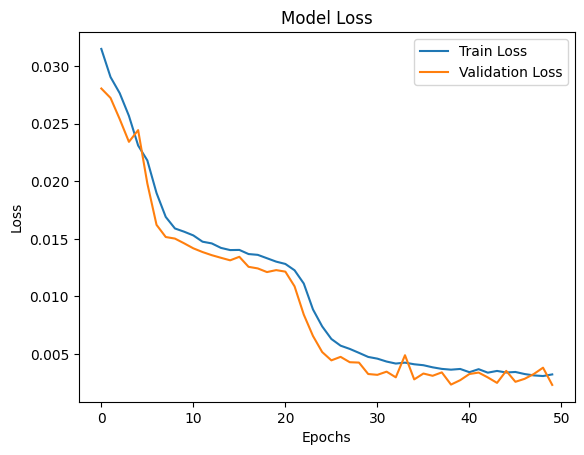

In [ ]:
# 6. 학습 과정 시각화 # 결과가 잘 나온 케이스
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
# 결과 0.023

In [15]:
# 7. 테스트 데이터 예측 - inverse transform 수치값을 원래의 형태로 변환
X_test = scaler_X.transform(test_data.values)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

y_pred = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred)

203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [17]:
# 결과 저장 - 예측된 값을 저장 -> 맨 처음 데이터셋 폴더에 저장이 됨
# test_predictions - 이름 마음대로 정해도 됨
test_data['predicted_count'] = y_pred
test_data.to_csv(dataset_path + 'test_bike_predictions.csv', index=False)
print("예측 결과가 'test_bike_predictions.csv'로 저장되었습니다.")

예측 결과가 'test_bike_predictions.csv'로 저장되었습니다.
